## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Load Data

In [2]:
def drop_missing(df):
    drop_columns = []
    for column in df.columns:
        if '?' in list(df[column].values):
            drop_columns.append(column)
    return df.drop(columns=drop_columns)

In [3]:
def load_dataset(filename):
    df = pd.read_csv(filename, header=None)
    df = df.drop(range(5), axis=1)
    df = drop_missing(df)
    X = np.array(df.iloc[:,:-1].values, dtype=float)
    y = np.array(df.iloc[:,-1].values, dtype=float)
    return X, y

In [4]:
X, y = load_dataset("communities.data")
X = StandardScaler().fit_transform(X)

In [5]:
parameters = [4.56316871e+01, 8.45220300e+00, 9.95727132e-02]

In [6]:
y_range = np.arange(np.min(y), np.max(y), 0.0001)

## Decorator for Vector Functions

In [7]:
def vectorizable(f):
    def f_(x):
        if hasattr(x, '__iter__'):
            return np.array([f(xi) for xi in x])
        return f(x)
    return f_

## Build Warping Function

In [8]:
def make_warper(parameters, y):
    y_mean = np.mean(y)
    y_std = np.std(y)
    def f(t):
        t = (t - y_mean) / (y_std * np.sqrt(len(y)))
        result = t
        for i in range(0, len(parameters), 3):
            a, b, c = parameters[i:(i+3)]
            result += a**2*math.tanh(b**2*(t + c))
        return result
    mean = np.mean([f(yi) for yi in y])
    @vectorizable
    def f_(t):
        return f(t) - mean
    @vectorizable
    def fp(t):
        t = (t - y_mean) / (y_std * np.sqrt(len(y)))
        result = 1.0
        for i in range(0, len(parameters), 3):
            a, b, c = parameters[i:(i+3)]
            u = math.tanh(b**2*(t + c))
            result += a**2*b**2*(1 - u**2)
        result /= y_std * np.sqrt(len(y))
        return result
    return f_, fp

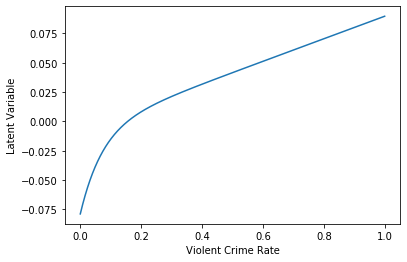

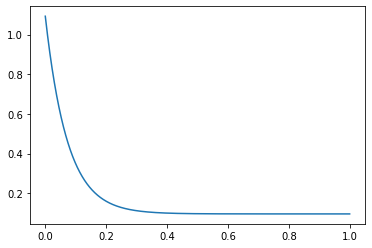

In [9]:
f, fp = make_warper(parameters, y)
plt.plot(y_range, f(y_range))
plt.xlabel("Violent Crime Rate")
plt.ylabel("Latent Variable")
plt.show()
plt.plot(y_range, fp(y_range))

## Compute Noise Stddev

In [11]:
def compute_noise_stddev(X, y, phi):
    f, fp = make_warper(phi, y)
    z = f(y)
    model = LinearRegression(fit_intercept=False)
    model.fit(X, z)
    z_pred = model.predict(X)
    rss = sum((z - z_pred)**2)
    num_regressors = X.shape[1] + 1 # Note, we add 1 since we also center the data
    return np.sqrt(rss / (len(y) - num_regressors))

In [12]:
noise_stddev = compute_noise_stddev(X, y, parameters)

## Compute Log-Likelihood Proxy of Training Data

In [13]:
def compute_log_likelihood_proxy(X, y, phi):
    f, fp = make_warper(phi, y)
    z = f(y)
    model = LinearRegression(fit_intercept=False)
    model.fit(X, z)
    z_pred = model.predict(X)
    rss = sum((z-z_pred)**2)
    return -len(y)/2*np.log(rss) + sum(np.log(fp(y)))

In [14]:
print(compute_log_likelihood_proxy(X, y, []))
print(compute_log_likelihood_proxy(X, y, parameters))

-3489.9892999776175
-2624.9579252356953


## Verify Maximum

In [15]:
def verify_log_likelihood_opt(X, y, phi):
    delta_x = 1.0e-3
    for i, phi_i in enumerate(phi):
        def f(x):
            phi_copy = np.array(phi)
            phi_copy[i] = x
            return compute_log_likelihood_proxy(X, y, phi_copy)
        f0 = f(phi_i)
        for x in [phi_i - delta_x, phi_i + delta_x]:
            delta_f = f(x) - f0
            relative_delta_f = delta_f / delta_x
            if relative_delta_f > 0 and np.abs(relative_delta_f) > 1.0e-3:
                print(i, x, "\t", delta_f, relative_delta_f)
                assert False, "Can't verify optimum"

In [16]:
verify_log_likelihood_opt(X, y, parameters)

## Invert Warping

In [17]:
def make_inverse(f):
    @vectorizable
    def f_inv(z):
        result = root_scalar(
            lambda x: f(x) - z, 
            fprime = fp,
            x0=(np.min(y) + np.max(y)) / 2, 
            method='newton')
        return result.root
    return f_inv

In [18]:
f_inv = make_inverse(f)
f_inv(0.1)

1.106879057268443

## Plot Error Distribution

Text(0.5, 0, 'Violent Crime Rate')

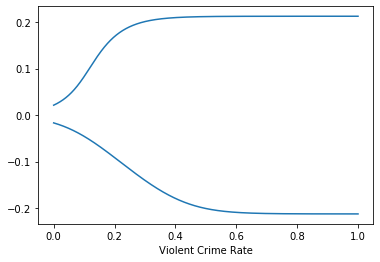

In [19]:
plt.plot(y_range, f_inv(f(y_range)-noise_stddev)-y_range, color='tab:blue')
plt.plot(y_range, f_inv(f(y_range)+noise_stddev)-y_range, color='tab:blue')
plt.xlabel("Violent Crime Rate")